In [1]:
import sys
sys.path.append("..")
import functools

import numpy as np
import torch
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt
from dict_minimize.torch_api import minimize
import functorch
import pyequion2

import tmcdiff

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
eqsys = pyequion2.EquilibriumBackend(["Na", "Cl"], from_elements=True, backend="torch", logbase="e",
                                     activity_model="DEBYE")

In [31]:
TK = 298.15
shear_velocity = 0.1
kinematic_viscosity = 1e-6
molal_balance = {'Na':0.01, 'Cl':0.01}

builder = tmcdiff.TransportBuilder(eqsys, TK, shear_velocity,
                           molal_balance, ["Halite"],
                           kreaction="inf")
builder.make_grid(3, 5)
builder.set_species()

In [32]:
builder.set_initial_guess_from_bulk()

In [33]:
solsimple = builder.solve_lma(simplified=True);
solfull = builder.solve_lma(simplified=False);
solsimple.success#, solfull.success

True

In [35]:
sol = builder.solve_gem_lagrangian()

In [37]:
sol.fun

array([ 2.11129081e-05, -3.39731574e-04, -1.03797619e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.12068428e-05, -6.72310326e-04,
       -1.45457431e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.52921677e-02,
       -1.41906741e-04, -9.99999978e-03,  1.76806512e-04,  0.00000000e+00,
        4.75270115e-03, -2.45161529e-04, -1.38181946e-04, -1.47527009e-02])

In [27]:
def torch_wrap(f):
    def g(x):
        x = torch.tensor(x, dtype=torch.float)
        res = f(x).detach().numpy()
        return res
    return g

def flat_residual(x):
    logcmu = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.full_residual(logcmu, lma=False, include_mu=False)
    return res.flatten()

flat_residual_jac = functorch.jacrev(flat_residual)

def lagrangian(xlambd):
    x, lambd = xlambd[:builder.nx], xlambd[builder.nx:]
    logc = x.reshape([builder.nspecies, builder.ngrid])
    mu = builder.chemical_potentials(logc).flatten()
    dresidual = flat_residual_jac(x)
    return mu + dresidual.T@lambd

def square_lagrangian(xlambd):
    return torch.mean(lagrangian(xlambd)**2)

square_lagrangian_jac = functorch.grad(square_lagrangian)

In [28]:
x0 = builder.xlambd.detach().numpy()
sol = scipy.optimize.minimize(torch_wrap(square_lagrangian),
                              x0,
                              jac=torch_wrap(square_lagrangian_jac),
                              method='L-BFGS-B')
sol

ValueError: failed in converting 7th argument `g' of _lbfgsb.setulb to C/Fortran array

In [30]:
x0 = torch.tensor(builder.xlambd, dtype=torch.float)
x0.requires_grad = True
optimizer = torch.optim.RMSprop([x0], lr=1e-1)
for i in range(1000):
    loss = square_lagrangian(x0)
    loss.backward()
    optimizer.step()
    print(loss)

/tmp/ipykernel_600/3232432064.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(builder.xlambd, dtype=torch.float)


tensor(3.1203e+09, grad_fn=<MeanBackward0>)
tensor(3.5686e+09, grad_fn=<MeanBackward0>)
tensor(4.4320e+08, grad_fn=<MeanBackward0>)
tensor(1.0153e+08, grad_fn=<MeanBackward0>)
tensor(32779820., grad_fn=<MeanBackward0>)
tensor(12191739., grad_fn=<MeanBackward0>)
tensor(4917720.5000, grad_fn=<MeanBackward0>)
tensor(2161121.7500, grad_fn=<MeanBackward0>)
tensor(1041411.2500, grad_fn=<MeanBackward0>)
tensor(567691.6250, grad_fn=<MeanBackward0>)
tensor(366372.0312, grad_fn=<MeanBackward0>)
tensor(281812.5938, grad_fn=<MeanBackward0>)
tensor(243618.4844, grad_fn=<MeanBackward0>)
tensor(220205.3125, grad_fn=<MeanBackward0>)
tensor(199653.5938, grad_fn=<MeanBackward0>)
tensor(180260.4219, grad_fn=<MeanBackward0>)
tensor(163606.0938, grad_fn=<MeanBackward0>)
tensor(150697.0156, grad_fn=<MeanBackward0>)
tensor(141644.0312, grad_fn=<MeanBackward0>)
tensor(135862.8750, grad_fn=<MeanBackward0>)
tensor(132697.4375, grad_fn=<MeanBackward0>)
tensor(131211.9062, grad_fn=<MeanBackward0>)
tensor(130744.9

tensor(144948.8438, grad_fn=<MeanBackward0>)
tensor(144911.9062, grad_fn=<MeanBackward0>)
tensor(144864.7031, grad_fn=<MeanBackward0>)
tensor(144883.0938, grad_fn=<MeanBackward0>)
tensor(144951.4062, grad_fn=<MeanBackward0>)
tensor(144990.3281, grad_fn=<MeanBackward0>)
tensor(144950.7656, grad_fn=<MeanBackward0>)
tensor(144876.4219, grad_fn=<MeanBackward0>)
tensor(144828.6562, grad_fn=<MeanBackward0>)
tensor(144818.1562, grad_fn=<MeanBackward0>)
tensor(144850.7031, grad_fn=<MeanBackward0>)
tensor(144936.0156, grad_fn=<MeanBackward0>)
tensor(144928.4844, grad_fn=<MeanBackward0>)
tensor(144785.2500, grad_fn=<MeanBackward0>)
tensor(144786.1250, grad_fn=<MeanBackward0>)
tensor(144978.4688, grad_fn=<MeanBackward0>)
tensor(144960.9844, grad_fn=<MeanBackward0>)
tensor(144804.7344, grad_fn=<MeanBackward0>)
tensor(144797.6094, grad_fn=<MeanBackward0>)
tensor(144807.8750, grad_fn=<MeanBackward0>)
tensor(144690.9844, grad_fn=<MeanBackward0>)
tensor(144561.8438, grad_fn=<MeanBackward0>)
tensor(144

tensor(145317.5469, grad_fn=<MeanBackward0>)
tensor(145276.6719, grad_fn=<MeanBackward0>)
tensor(145235.4062, grad_fn=<MeanBackward0>)
tensor(145192.2969, grad_fn=<MeanBackward0>)
tensor(145158.7500, grad_fn=<MeanBackward0>)
tensor(145161.7812, grad_fn=<MeanBackward0>)
tensor(145163.1406, grad_fn=<MeanBackward0>)
tensor(145171.6094, grad_fn=<MeanBackward0>)
tensor(145251.0469, grad_fn=<MeanBackward0>)
tensor(145189.2656, grad_fn=<MeanBackward0>)
tensor(145237.9062, grad_fn=<MeanBackward0>)
tensor(145272.9219, grad_fn=<MeanBackward0>)
tensor(145291.4062, grad_fn=<MeanBackward0>)
tensor(145306.1719, grad_fn=<MeanBackward0>)
tensor(145212.6250, grad_fn=<MeanBackward0>)
tensor(145138.0469, grad_fn=<MeanBackward0>)
tensor(145176.3750, grad_fn=<MeanBackward0>)
tensor(145289.1406, grad_fn=<MeanBackward0>)
tensor(145370.9531, grad_fn=<MeanBackward0>)
tensor(145371.0469, grad_fn=<MeanBackward0>)
tensor(145337.8438, grad_fn=<MeanBackward0>)
tensor(145324.1719, grad_fn=<MeanBackward0>)
tensor(145

tensor(146278.7188, grad_fn=<MeanBackward0>)
tensor(146266.6250, grad_fn=<MeanBackward0>)
tensor(146262.2500, grad_fn=<MeanBackward0>)
tensor(146261.9062, grad_fn=<MeanBackward0>)
tensor(146266.7969, grad_fn=<MeanBackward0>)
tensor(146275.7344, grad_fn=<MeanBackward0>)
tensor(146268.5625, grad_fn=<MeanBackward0>)
tensor(146211.3438, grad_fn=<MeanBackward0>)
tensor(146111.5625, grad_fn=<MeanBackward0>)
tensor(146063.8594, grad_fn=<MeanBackward0>)
tensor(146129.7344, grad_fn=<MeanBackward0>)
tensor(146228.3125, grad_fn=<MeanBackward0>)
tensor(146257.8438, grad_fn=<MeanBackward0>)
tensor(146184.9062, grad_fn=<MeanBackward0>)
tensor(146120.2656, grad_fn=<MeanBackward0>)
tensor(146156.2031, grad_fn=<MeanBackward0>)
tensor(146219.1250, grad_fn=<MeanBackward0>)
tensor(146239.5938, grad_fn=<MeanBackward0>)
tensor(146227.2656, grad_fn=<MeanBackward0>)
tensor(146212.2969, grad_fn=<MeanBackward0>)
tensor(146241.3594, grad_fn=<MeanBackward0>)
tensor(146312.6562, grad_fn=<MeanBackward0>)
tensor(146

tensor(147270.7500, grad_fn=<MeanBackward0>)
tensor(147273.8594, grad_fn=<MeanBackward0>)
tensor(147216.0469, grad_fn=<MeanBackward0>)
tensor(147159.0781, grad_fn=<MeanBackward0>)
tensor(147148.1875, grad_fn=<MeanBackward0>)
tensor(147092.3750, grad_fn=<MeanBackward0>)
tensor(147093.3750, grad_fn=<MeanBackward0>)
tensor(147078.0469, grad_fn=<MeanBackward0>)
tensor(147120.9375, grad_fn=<MeanBackward0>)
tensor(147252.7031, grad_fn=<MeanBackward0>)
tensor(147451.2344, grad_fn=<MeanBackward0>)
tensor(147630.7812, grad_fn=<MeanBackward0>)
tensor(147636.0625, grad_fn=<MeanBackward0>)
tensor(147434.1875, grad_fn=<MeanBackward0>)
tensor(147197.9062, grad_fn=<MeanBackward0>)
tensor(147035.8438, grad_fn=<MeanBackward0>)
tensor(147018.6250, grad_fn=<MeanBackward0>)
tensor(147130.1562, grad_fn=<MeanBackward0>)
tensor(147345.1562, grad_fn=<MeanBackward0>)
tensor(147508.7969, grad_fn=<MeanBackward0>)
tensor(147286.4688, grad_fn=<MeanBackward0>)
tensor(147438.2656, grad_fn=<MeanBackward0>)
tensor(147

In [62]:
logcmu = sol.x[:builder.nx].reshape(builder.nspecies, builder.ngrid)
logc = logcmu[:builder.nspecies, :]
c = np.exp(logc)
logc_t = torch.tensor(logc, dtype=torch.float)

Text(0.5, 0, '$y^+$')

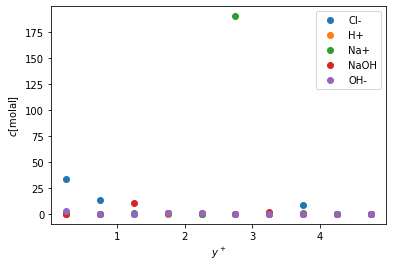

In [63]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')